In [16]:
# Imports
import audio_processing as ap
from sklearn.preprocessing import normalize
import numpy as np
from network import HopfieldNetwork
import matplotlib.pyplot as plt

In [4]:
# Generate sine waves (and save as wav files)

# Dictionary with all the frequencies and their associatd piano pitches
piano_frequencies = {
    55.00: 'A1', 58.27: 'A#1/Bb1',
    61.74: 'B1', 
    65.41: 'C2', 69.30: 'C#2/Db2',
    73.42: 'D2', 77.78: 'D#2/Eb2',
    82.41: 'E2', 87.31: 'F2', 92.50: 'F#2/Gb2',
    98.00: 'G2', 103.83: 'G#2/Ab2',
    110.00: 'A2', 116.54: 'A#2/Bb2',
    123.47: 'B2',
    130.81: 'C3', 138.59: 'C#3/Db3',
    146.83: 'D3', 155.56: 'D#3/Eb3',
    164.81: 'E3', 174.61: 'F3', 185.00: 'F#3/Gb3',
    196.00: 'G3', 207.65: 'G#3/Ab3',
    220.00: 'A3', 233.08: 'A#3/Bb3',
    246.94: 'B3',
    261.63: 'C4', 277.18: 'C#4/Db4',
    293.66: 'D4', 311.13: 'D#4/Eb4',
    329.63: 'E4', 349.23: 'F4', 369.99: 'F#4/Gb4',
    392.00: 'G4', 415.30: 'G#4/Ab4',
    440.00: 'A4', 466.16: 'A#4/Bb4',
    493.88: 'B4',
    523.25: 'C5', 554.37: 'C#5/Db5',
    587.33: 'D5', 622.25: 'D#5/Eb5',
    659.25: 'E5', 698.46: 'F5', 739.99: 'F#5/Gb5',
    783.99: 'G5', 830.61: 'G#5/Ab5',
    880.00: 'A5', 932.33: 'A#5/Bb5',
    987.77: 'B5',
    1046.50: 'C6', 1108.73: 'C#6/Db6',
    1174.66: 'D6', 1244.51: 'D#6/Eb6',
    1318.51: 'E6', 1396.91: 'F6', 1479.98: 'F#6/Gb6',
    1567.98: 'G6', 1661.22: 'G#6/Ab6',
    1760.00: 'A6'
}

clean_folder_path = "./audio/original_sine_waves/"

for frequency in piano_frequencies:
    file_name = clean_folder_path + f"{frequency}.wav"
    ap.generate_sine_wave_file(file_name, frequency=frequency)

In [8]:
# Add noise to sine waves (and save as wav files)

noisy_folder_path = "./audio/noisy_sine_waves/"

for frequency in piano_frequencies:
    clean_file = clean_folder_path + f"{frequency}.wav"
    noisy_file = noisy_folder_path + f"{frequency}.wav"
    ap.add_noise_to_wav(clean_file, noisy_file, noise_level=10000)

In [58]:
# Preprocess into a train and test dataset

train_data = []
test_data = []

mel_bins = 3000 # Hyperparameter
bit_precision = 8 # Hyperparameter

for frequency in list(piano_frequencies.keys()): # Slice for reduced size
    clean_file = clean_folder_path + f"{frequency}.wav"
    noisy_file = noisy_folder_path + f"{frequency}.wav"

    # Get the mel spectrogram
    clean_mags, clean_freqs = ap.compute_mel_spectrogram(clean_file, num_mel_filters=mel_bins)
    noisy_mags, noisy_freqs = ap.compute_mel_spectrogram(noisy_file, num_mel_filters=mel_bins)

    # Find frequency where it's above the range... TODO: maybe delete this
    index = np.where(clean_freqs > 10000)[0][0]
    clean_mags = clean_mags[:index]
    clean_freqs = clean_freqs[:index]
    noisy_mags = noisy_mags[:index]
    noisy_freqs = noisy_freqs[:index]

    # Normalize then binarize the data
    clean_norm_bin = ap.binarize_audio(normalize(clean_mags.reshape(-1, 1), axis=0), bit_precision)
    noisy_norm_bin = ap.binarize_audio(normalize(noisy_mags.reshape(-1, 1), axis=0), bit_precision)

    # Flatten the data for network
    clean_flat = np.reshape(clean_norm_bin, (len(clean_norm_bin) * bit_precision))
    noisy_flat = np.reshape(noisy_norm_bin, (len(noisy_norm_bin) * bit_precision))

    # Add to dataset
    train_data.append(clean_flat)
    test_data.append(noisy_flat)

In [59]:
# Initialize and train Hopfield net on clean audio
model = HopfieldNetwork()

model.train_weights(train_data)

Start to train weights...
Weights initialized
(18800, 18800)


100%|██████████| 61/61 [01:55<00:00,  1.89s/it]


Hebb rule step done


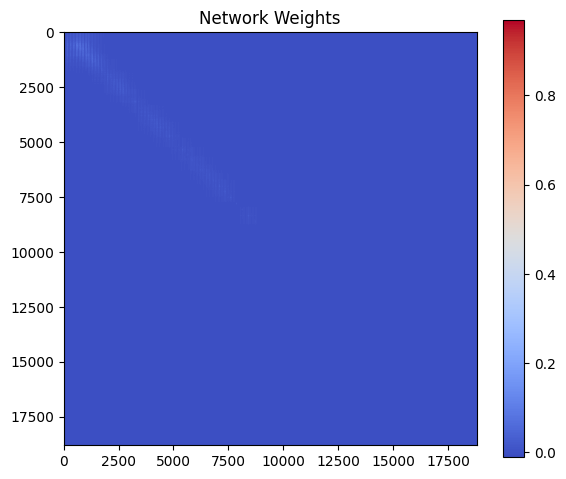

In [60]:
# Plot the network weights
model.plot_weights()

In [63]:
# Get predictions with the Hopfield net from the noisy audio
predictions = model.predict(test_data, num_iter=10, threshold=20, asyn=False)

Start to predict...


100%|██████████| 61/61 [12:29<00:00, 12.28s/it]


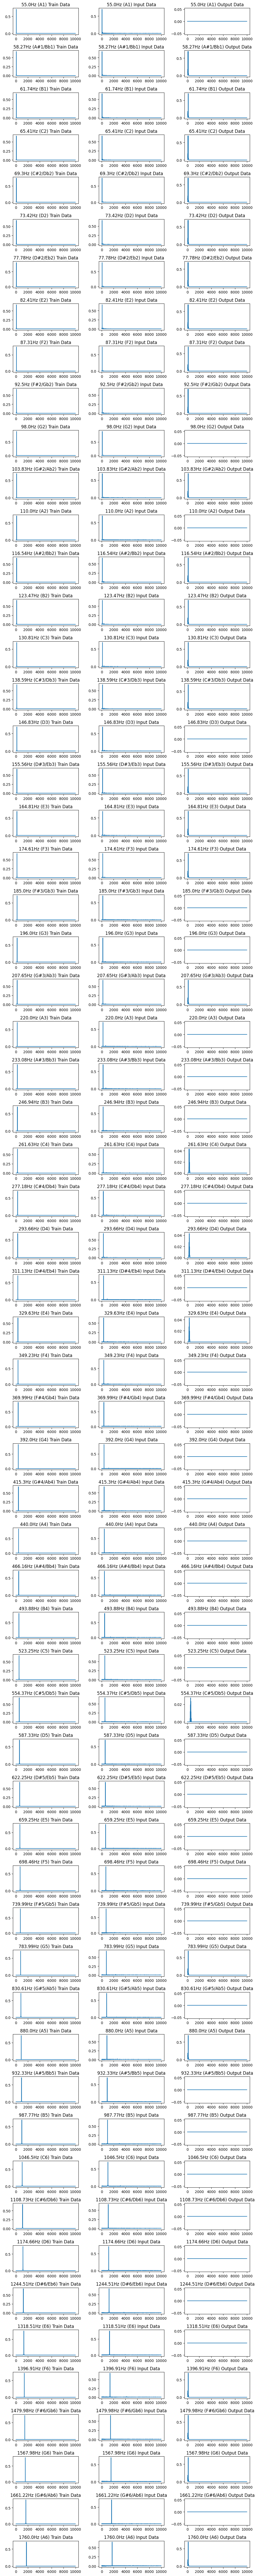

In [68]:
# Plot some example training vs predictions

figure, axes = plt.subplots(len(predictions), 3, figsize=(10,100))

freq_keys = list(piano_frequencies.keys())

c = 0
for i in range(0, len(predictions)):
    original = np.array(train_data[i]).reshape(len(train_data[i]) // bit_precision, bit_precision)
    noisy = np.array(test_data[i]).reshape(len(test_data[i]) // bit_precision, bit_precision)
    cleaned = np.array(predictions[i]).reshape(len(predictions[i]) // bit_precision, bit_precision)

    original = ap.unbinarize_data(original)
    noisy = ap.unbinarize_data(noisy)
    cleaned = ap.unbinarize_data(cleaned)

    axes[c, 0].set_title(f"{freq_keys[i]}Hz ({piano_frequencies[freq_keys[i]]}) Train Data")
    axes[c, 1].set_title(f"{freq_keys[i]}Hz ({piano_frequencies[freq_keys[i]]}) Input Data")
    axes[c, 2].set_title(f"{freq_keys[i]}Hz ({piano_frequencies[freq_keys[i]]}) Output Data")

    axes[c, 0].plot(clean_freqs, original)
    axes[c, 1].plot(clean_freqs, noisy)
    axes[c, 2].plot(clean_freqs, cleaned)
    
    c += 1

plt.tight_layout()
plt.savefig("./figures/simple_analysis/predictions.png")
plt.show()


In [ ]:
# Make some plots showing how recovery accuracy changes with hyperparameters (noise level, threshold, num_iter, etc)

In [ ]:
# Make some plots showing how recovery accuracy changes with number of memories stored